In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


# Multi Label Classification

### In Multi label classification, every row can correspond to multiple classes

## Import libraries

In [39]:
!pip install -qq iterative-stratification

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import early_stopping,log_evaluation, Dataset
import lightgbm as lgb
import optuna
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score
import joblib
import pickle
from optuna.samplers import TPESampler

## Exploratory data analysis

In [41]:
data = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv',low_memory=False)
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv',low_memory=False)

In [42]:
data.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


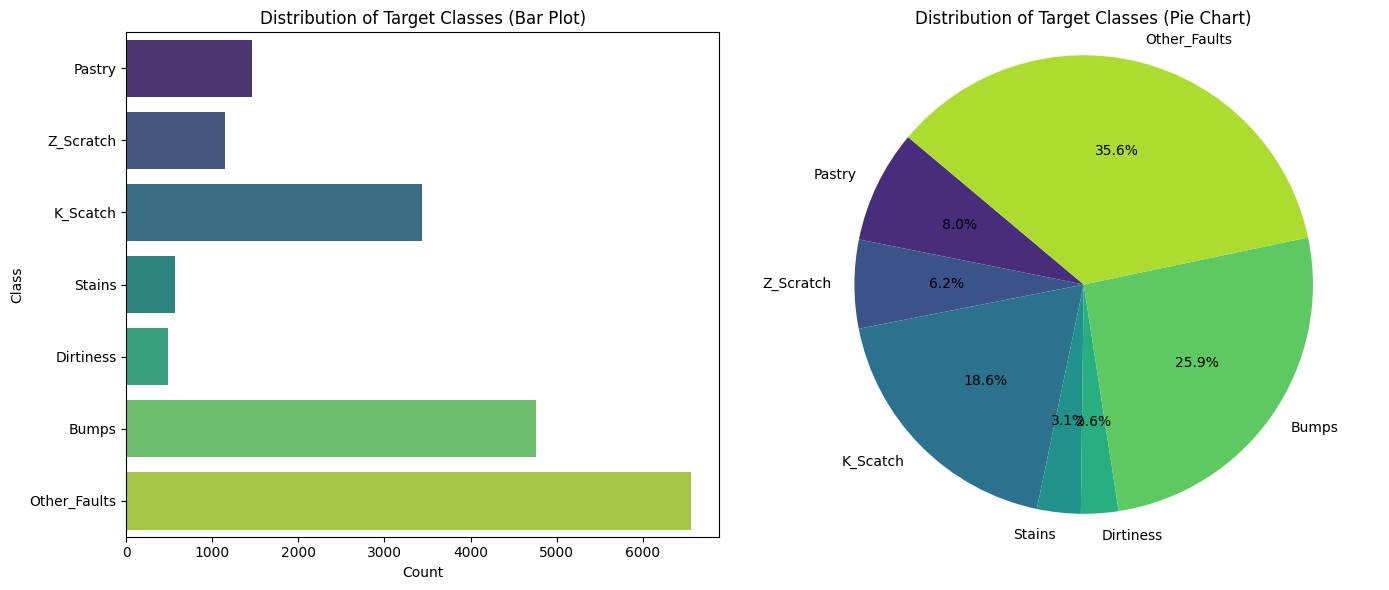

In [43]:
# data.dtypes no strings
# data.isnull().sum() zero nan values
# data.duplicated().sum() bo duplicate rows

# Visualize the distribution of each target class
target = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target_counts = data[target].sum()

# Define color palette
colors = sns.color_palette('viridis', len(target))

# Plot horizontal bar plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(y=target_counts.index, x=target_counts.values, palette=colors)
plt.title('Distribution of Target Classes (Bar Plot)')
plt.xlabel('Count')
plt.ylabel('Class')

# Plot pie chart
plt.subplot(1, 2, 2)
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.axis('equal')
plt.title('Distribution of Target Classes (Pie Chart)')

plt.tight_layout()
plt.show()


## Feature generator

### We generate additional features basd off of prexisting features to help our models find more patterns in the data

In [44]:
def preprocess_data(data):
    epsilon = 1e-6  # A small constant to avoid division by zero or taking the logarithm of zero
    # Location Features
    data['X_Distance'] = data['X_Maximum'] - data['X_Minimum']
    data['Y_Distance'] = data['Y_Maximum'] - data['Y_Minimum']

    # Density Feature
    data['Density'] = data['Pixels_Areas'] / (data['X_Perimeter'] + data['Y_Perimeter'])

    # Relative Perimeter Feature
    data['Relative_Perimeter'] = data['X_Perimeter'] / (data['X_Perimeter'] + data['Y_Perimeter'] + epsilon)

    # Circularity Feature
    data['Circularity'] = data['Pixels_Areas'] / (data['X_Perimeter'] ** 2)

    # Symmetry Index Feature
    data['Symmetry_Index'] = np.abs(data['X_Distance'] - data['Y_Distance']) / (data['X_Distance'] + data['Y_Distance'] + epsilon)
    
    # Color Contrast Feature
    data['Color_Contrast'] = data['Maximum_of_Luminosity'] - data['Minimum_of_Luminosity']

    # Combined Geometric Index Feature
    data['Combined_Geometric_Index'] = data['Edges_Index'] * data['Square_Index']

    # Interaction Term Feature
    data['X_Distance*Pixels_Areas'] = data['X_Distance'] * data['Pixels_Areas']

    # Additional Features
    data['sin_orientation'] = np.sin(data['Orientation_Index'])
    data['Edges_Index2'] = np.exp(data['Edges_Index'] + epsilon)
    data['X_Maximum2'] = np.sin(data['X_Maximum'])
    data['Y_Minimum2'] = np.sin(data['Y_Minimum'])
    data['Aspect_Ratio_Pixels'] = np.where(data['Y_Perimeter'] == 0, 0, data['X_Perimeter'] / data['Y_Perimeter'])
    data['Aspect_Ratio'] = np.where(data['Y_Distance'] == 0, 0, data['X_Distance'] / data['Y_Distance'])

    # Average Luminosity Feature
    data['Average_Luminosity'] = (data['Sum_of_Luminosity'] + data['Minimum_of_Luminosity']) / 2
    
    # Normalized Steel Thickness Feature
    data['Normalized_Steel_Thickness'] = (data['Steel_Plate_Thickness'] - data['Steel_Plate_Thickness'].min()) / (data['Steel_Plate_Thickness'].max() - data['Steel_Plate_Thickness'].min())

    # Logarithmic Features
    data['Log_Perimeter'] = np.log(data['X_Perimeter'] + data['Y_Perimeter'] + epsilon)
    data['Log_Luminosity'] = np.log(data['Sum_of_Luminosity'] + epsilon)
    data['Log_Aspect_Ratio'] = np.log(data['Aspect_Ratio'] ** 2 + epsilon)

    # Statistical Features
    data['Combined_Index'] = data['Orientation_Index'] * data['Luminosity_Index']
    data['Sigmoid_Areas'] = 1 / (1 + np.exp(-data['LogOfAreas'] + epsilon))

    return data

data = preprocess_data(data)
test = preprocess_data(test)

# Specify X and y

In [45]:
target = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
X = data.drop(columns=target + ['id'], axis=1)
y = data[target]

## We apply a Robust scaler to continuous features

Robust scaler scales features using statistics that are robust to outliers. This scaler removes the median and scales the data according to the interquartile range (IQR). Its particuarly useful for skewed data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test = scaler.transform(test.drop(columns=['id'], axis=1))
y = data[target]

# Experimenting with Principal Component Analysis

In [47]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

num_components = 8  # Specify the number of components
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance_ratio = pca.explained_variance_ratio_
loadings = pca.components_
display(explained_variance_ratio)

array([0.33745979, 0.10761445, 0.05933483, 0.04704892, 0.04064936,
       0.03750981, 0.03354361, 0.030472  ])

The explained variance ratio obtained from PCA indicates the proportion of variance explained by each principal component. In your case, with num_components = 10, you've performed PCA to reduce the dimensionality of your data to 10 principal components. The explained_variance_ratio_ array you provided suggests that the first principal component explains approximately 36.66% of the total variance in the data, while the second principal component explains approximately 11.32% of the total variance.



### Scatterplots showing the relationships between the two first PCA components and tha target classes

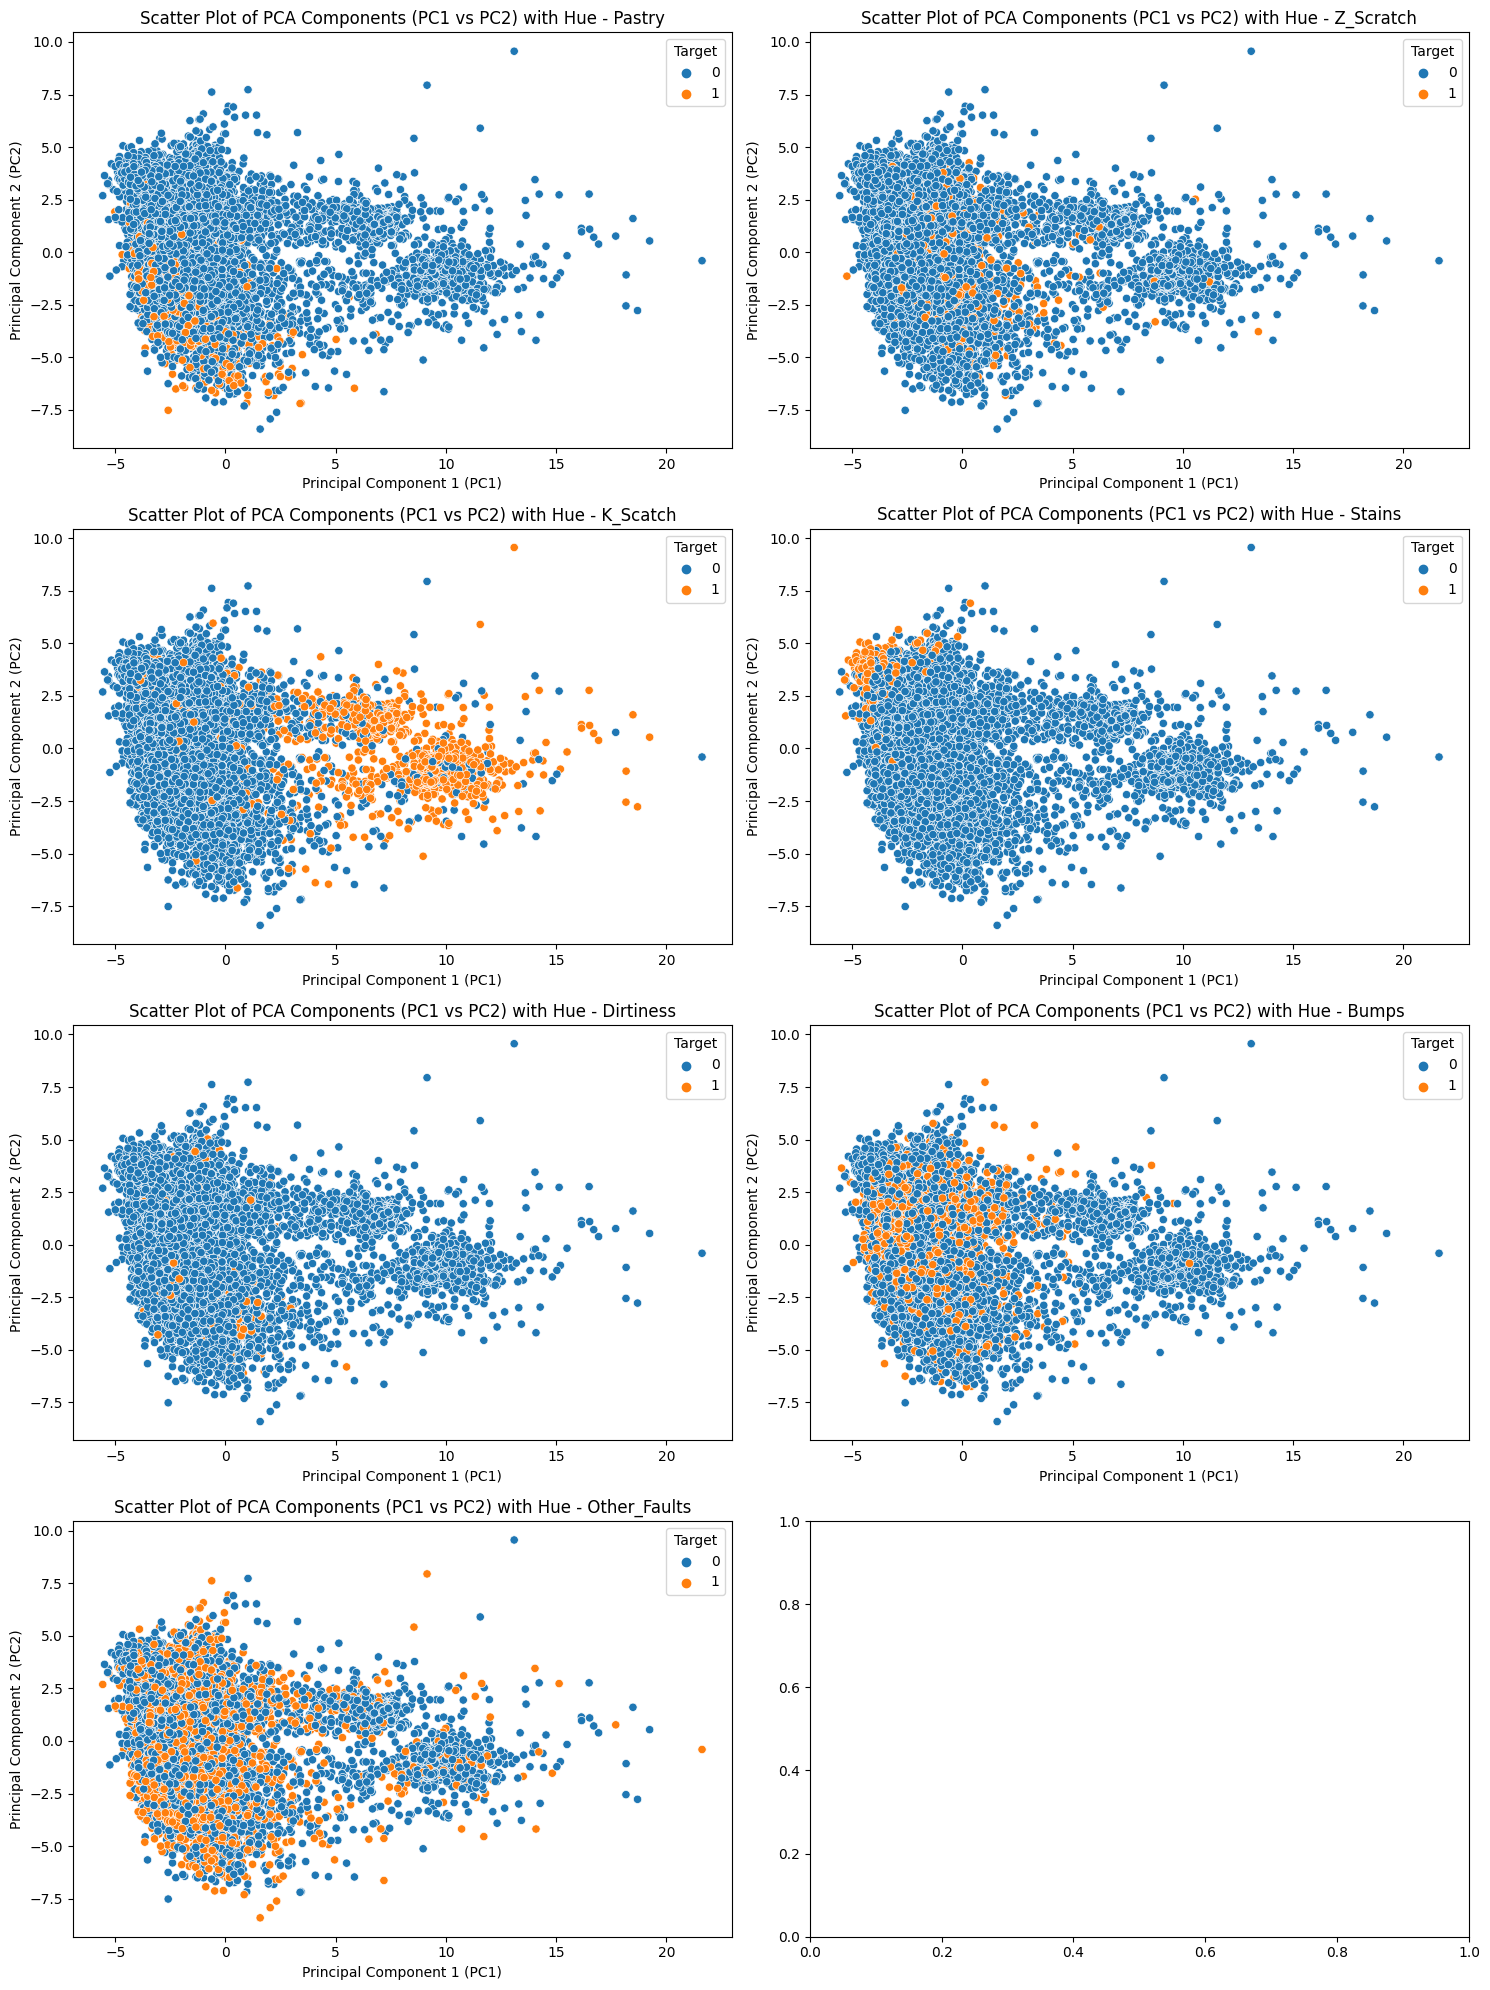

In [48]:
# Define the number of rows and columns in the subplot grid
num_rows = (len(y.columns) + 1) // 2  # Adjust as needed
num_cols = 2  # Adjust as needed

# Create the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten the axes if necessary
if len(y.columns) > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Iterate over each target column and create a scatter plot
for i, column in enumerate(y.columns):
    # Combine the PCA-transformed features with the selected target variable
    pca_df = pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(num_components)])
    pca_df[column] = y_train[column].values

    # Plot the scatter plot with hue
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=column, ax=axes[i])
    axes[i].set_title(f'Scatter Plot of PCA Components (PC1 vs PC2) with Hue - {column}')
    axes[i].set_xlabel('Principal Component 1 (PC1)')
    axes[i].set_ylabel('Principal Component 2 (PC2)')
    axes[i].legend(title='Target')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## A bar plot shoiwng the proportion of variance explained from the PCA components.

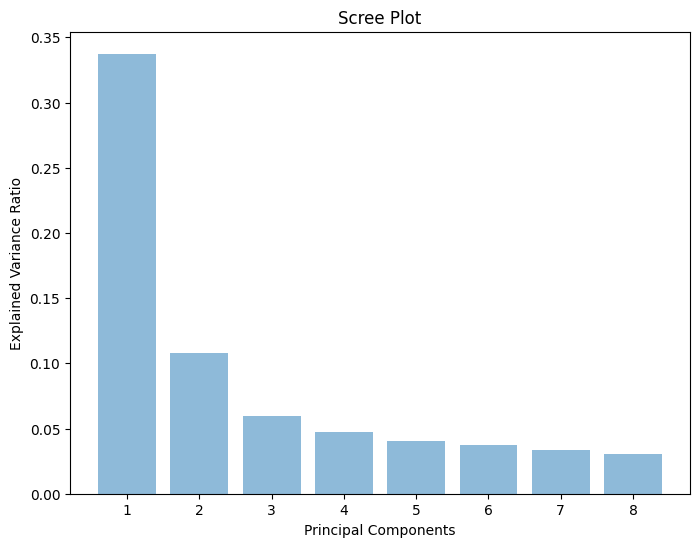

In [49]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, num_components + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()


### We create a correlation matrix showing the correlation between the PCA components and the features.


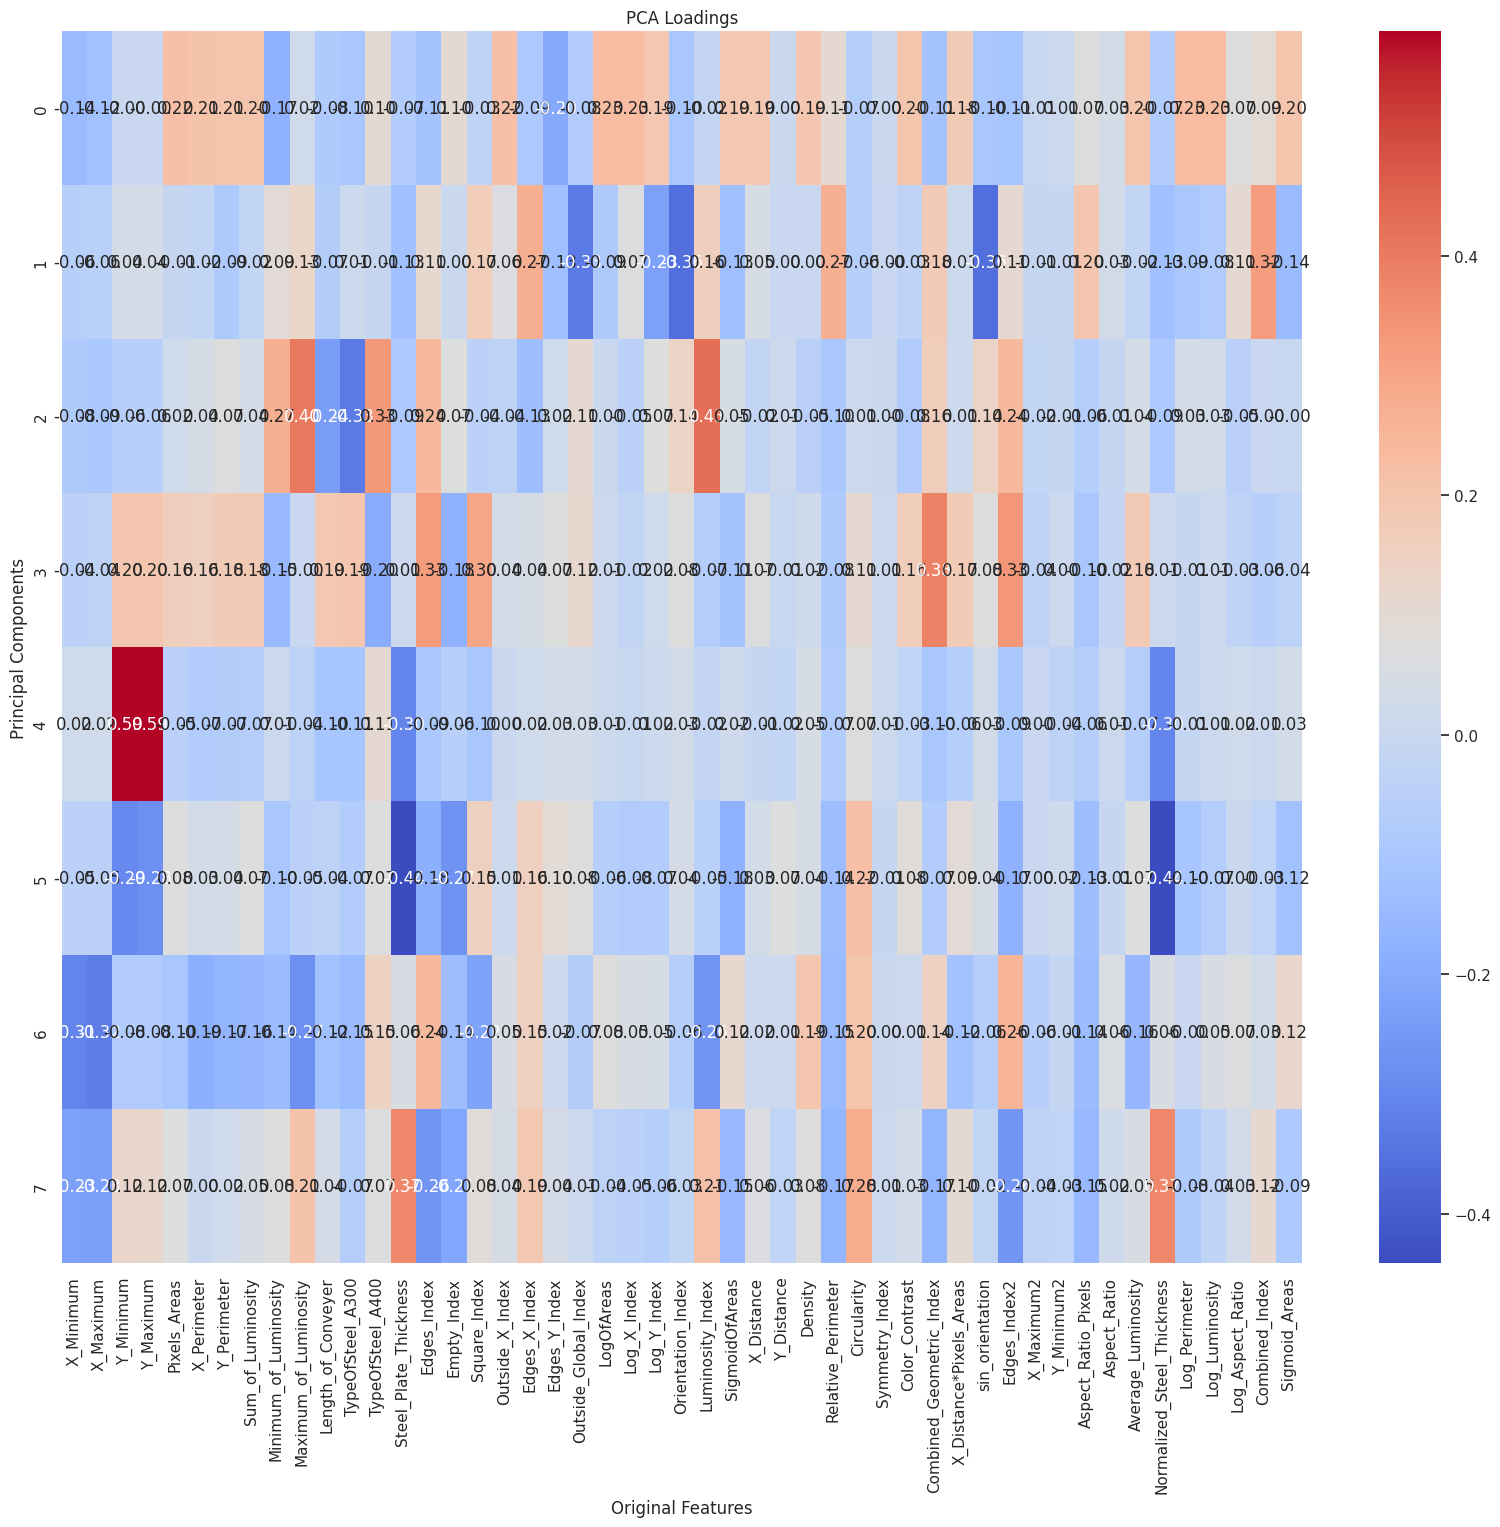

In [88]:
plt.figure(figsize=(20, 16))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt='.2f', xticklabels=X.columns)
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.title('PCA Loadings')
plt.show()

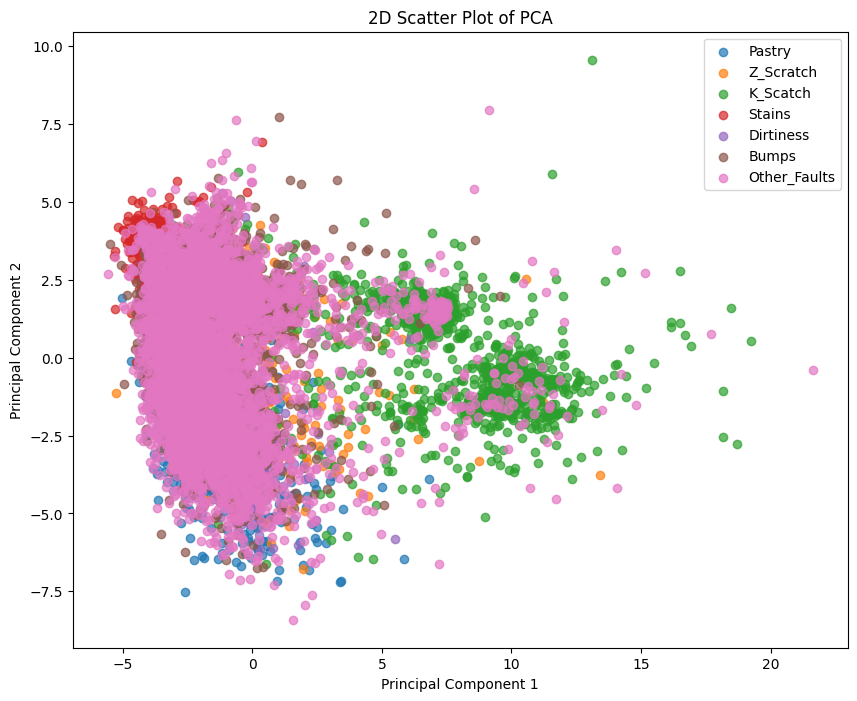

In [51]:
plt.figure(figsize=(10, 8))
for fault_type in y_train.columns:
    plt.scatter(X_train_pca[y_train[fault_type] == 1, 0], 
                X_train_pca[y_train[fault_type] == 1, 1], 
                label=fault_type, alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Scatter Plot of PCA')
plt.legend()
plt.show()


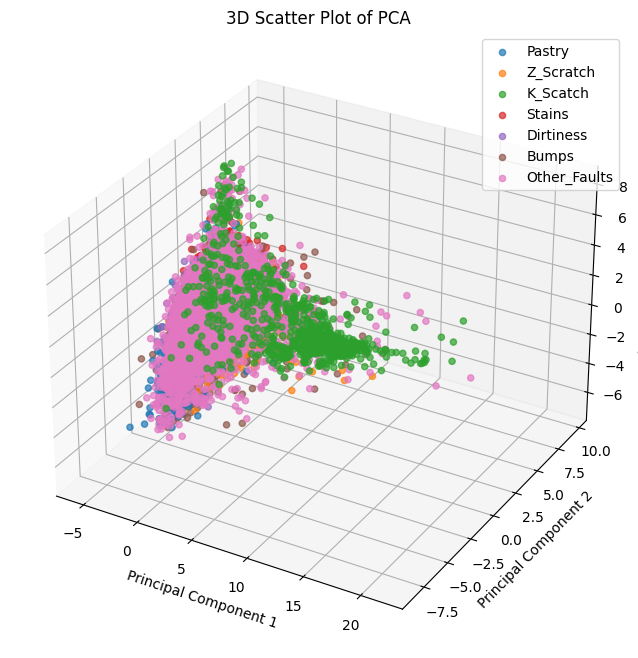

In [52]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for fault_type in y_train.columns:
    ax.scatter(X_train_pca[y_train[fault_type] == 1, 0], 
               X_train_pca[y_train[fault_type] == 1, 1], 
               X_train_pca[y_train[fault_type] == 1, 2], 
               label=fault_type, alpha=0.7)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Scatter Plot of PCA')
ax.legend()
plt.show()


In [53]:
# Define several helper functions
from sklearn.metrics import roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

def avg_auc(y_true, y_pred):
    roc_auc_scores = []
    for i in range(y_true.shape[1]):
        y_true_col = y_true.iloc[:, i]
        y_pred_col = y_pred[i][:, 1]
        roc_auc = roc_auc_score(y_true_col, y_pred_col)
        roc_auc_scores.append(roc_auc)
    average_roc_auc = np.mean(roc_auc_scores)
    return average_roc_auc

def cv_eval(X_train, y_train, model):
    mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in mskf.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train[train_idx], y_train.iloc[train_idx]
        X_valid_fold, y_valid_fold = X_train[valid_idx], y_train.iloc[valid_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict_proba(X_valid_fold)
        score = avg_auc(y_valid_fold, y_pred_fold)
        scores.append(score)

    print("Average ROC AUC score:", np.mean(scores))

def plot_importance(model, features):
    # Plot the top 10 feature importance
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)[::-1] 
    top_ten_indices = indices[:10]
    plt.figure(figsize=(8, 6))
    plt.title('Top 10 Feature Importances')
    plt.barh(range(10), feature_importances[top_ten_indices], color='k', align='center')
    plt.yticks(range(10), features.columns[top_ten_indices])
    plt.xlabel('Relative Importance')
    plt.gca().invert_yaxis()
    plt.show()

def plot_multi_importance(model, X):
    # Plot the top 10 feature importance for multioutput classifier
    all_importances = np.array([estimator.feature_importances_ for estimator in model.estimators_])
    avg_importances = np.mean(all_importances, axis=0)
    indices = np.argsort(avg_importances)[::-1]
    top_ten_indices = indices[:10]

    plt.figure(figsize=(8, 6))
    plt.title('Top 10 Feature Importances')
    plt.barh(range(10), avg_importances[top_ten_indices], color='k', align='center')
    if X.columns.any():
        plt.yticks(range(10), X.columns[top_ten_indices])
    else:
        plt.yticks(range(10), top_ten_indices)
    plt.xlabel('Relative Importance')
    plt.gca().invert_yaxis()
    plt.show()

### We create function which will plot the area under the recieving operating curve for each target

Normally AUC is used in binary classification. Since this is a multi label classification, we treat each target as a binary target

Top Feature Subsets based on Importance:
                    Feature  Importance
17          Outside_X_Index    0.041474
27               X_Distance    0.036444
35  X_Distance*Pixels_Areas    0.035493
22              Log_X_Index    0.030596
10       Length_of_Conveyer    0.028136
44            Log_Perimeter    0.027165
42       Average_Luminosity    0.026772
21               LogOfAreas    0.026581
48            Sigmoid_Areas    0.026370
33           Color_Contrast    0.025640


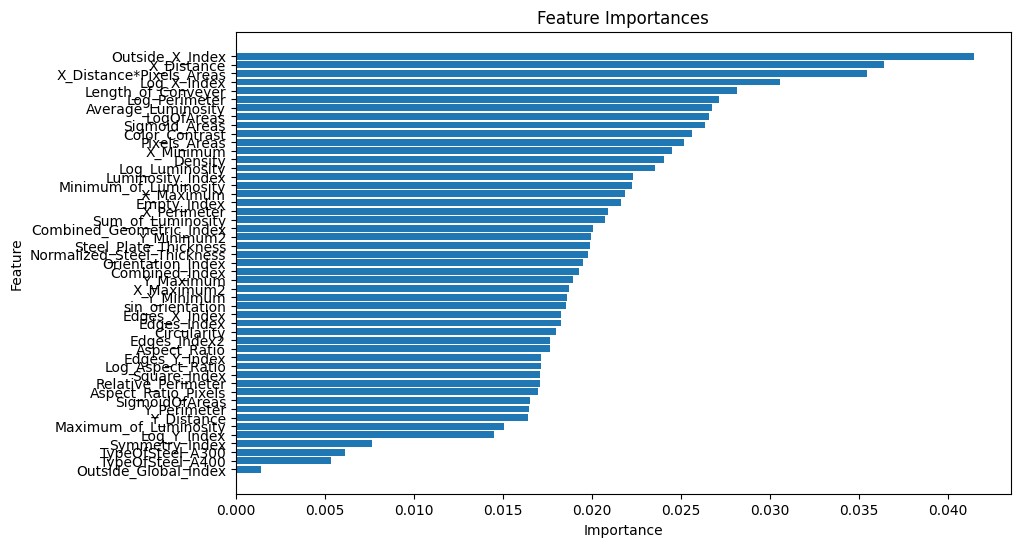

In [56]:
# Initialize RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Fit classifier on training data
clf.fit(X_train, y_train)

# Extract feature importances
importances = clf.feature_importances_

# Combine feature names and importances into a DataFrame
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort feature importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top feature subsets based on importance
print("Top Feature Subsets based on Importance:")
print(feature_importance_df.head(10))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

## We include a neural network

### Notice our output layer is a sigmoid function since this is multi label classification. We predict the probability of a row corresponding to one of our target classes independent on the other taregt classes

### The output of this network will be a vector of probabilities for each class, where each element represents the probability of the corresponding class being present in the input instance.

### We train our neural network using the Adam optimizer. Our Loss function is binary cross entropy

The binary cross-entropy loss function is given by:

$$
L(y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
$$

Where:
- $N$ is the number of samples.
- $y_i$ is the true label (either 0 or 1) for the \(i\)-th sample.
- $\hat{y}_i$ is the predicted probability of the positive class for the \(i\)-th sample.

We update the weights and biases through the gradient descent algorithm. We compute the partial derivative of the loss function with respect to each of the networks weights by every layer in the networl, and change the weights by the learning rate $\alpha$ in the direction such that the slope of the tangent line on the loss function will come closer to a global minimum point. We do this process 'epoch' times

$$\frac{\partial C}{\partial W} =  \frac{\partial z}{\partial W} \frac{\partial a}{\partial z} \frac{\partial C}{\partial a}$$

### Prepare my data for the network

In [57]:
device=("cuda" if torch.cuda.is_available() else "cpu")

# Convert input features to tensor
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(np.array(y_test), dtype=torch.float32).to(device)


In [58]:
train_dataset=TensorDataset(X_train_tensor,y_train_tensor)
test_dataset=TensorDataset(X_val_tensor,y_val_tensor)
train_loader=DataLoader(train_dataset,batch_size=256)
test_loader=DataLoader(test_dataset,batch_size=256)

In [59]:
input_size = X.shape[1]
num_classes = len(target)
hidden_size = 1700

## We create a multi perceptron neural network class

Our network used GELU for experimentation to introduce non-linearity in our model. We use batch normalization to prevent overfitting. We utilize a concept called skip-connections which was introduced in the paper of the resnet.
Skip connections make the output of one layer is added to the output of a previous layer, bypassing one or more intermediate layers. These connections aim to mitigate the vanishing gradient problem and enable better flow of gradients during training, especially in deep neural networks. This has shown to create better generalization performance of this specific problem

In [60]:
class MLPBlock(nn.Module):
    def __init__(self, input_size, hidden_size, dropout):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),  # GELU activation function
            nn.Dropout(dropout),
            nn.Linear(hidden_size, input_size),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(input_size)

    def forward(self, x):
        norm = self.bn(x)
        h = self.mlp(norm)
        return h + x  # Skip connection

class MLP(nn.Module):
    def __init__(self, input_size, num_blocks=6, mlp_mult=4, dropout=0.2, output_size=7):
        super().__init__()
        self.block = nn.ModuleList([MLPBlock(input_size, input_size * mlp_mult, dropout) for _ in range(num_blocks)])
        self.linear = nn.Linear(input_size, input_size)
        self.normout = nn.BatchNorm1d(input_size)
        self.out = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        proj = self.linear(x)
        for blk in self.block:
            proj = blk(proj)
        rep = self.normout(proj)
        return self.out(rep)

### We define the training function

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 1: 100%|██████████| 53/53 [00:01<00:00, 38.34batch/s, loss=0.579]


Adjusting learning rate of group 0 to 9.9994e-04.


Epoch 2: 100%|██████████| 53/53 [00:01<00:00, 44.46batch/s, loss=0.435]


Adjusting learning rate of group 0 to 9.9975e-04.


Epoch 3: 100%|██████████| 53/53 [00:01<00:00, 35.77batch/s, loss=0.316]


Adjusting learning rate of group 0 to 9.9944e-04.


Epoch 4: 100%|██████████| 53/53 [00:01<00:00, 39.47batch/s, loss=0.267]


Adjusting learning rate of group 0 to 9.9901e-04.


Epoch 5: 100%|██████████| 53/53 [00:01<00:00, 47.86batch/s, loss=0.25] 


Adjusting learning rate of group 0 to 9.9846e-04.


Epoch 6: 100%|██████████| 53/53 [00:01<00:00, 46.09batch/s, loss=0.238]


Adjusting learning rate of group 0 to 9.9778e-04.


Epoch 7: 100%|██████████| 53/53 [00:01<00:00, 45.51batch/s, loss=0.236]


Adjusting learning rate of group 0 to 9.9698e-04.


Epoch 8: 100%|██████████| 53/53 [00:01<00:00, 42.97batch/s, loss=0.231]


Adjusting learning rate of group 0 to 9.9606e-04.


Epoch 9: 100%|██████████| 53/53 [00:01<00:00, 46.38batch/s, loss=0.228]


Adjusting learning rate of group 0 to 9.9501e-04.


Epoch 10: 100%|██████████| 53/53 [00:01<00:00, 45.81batch/s, loss=0.228]


Adjusting learning rate of group 0 to 9.9384e-04.


Epoch 11: 100%|██████████| 53/53 [00:01<00:00, 46.78batch/s, loss=0.227]


Adjusting learning rate of group 0 to 9.9255e-04.


Epoch 12: 100%|██████████| 53/53 [00:01<00:00, 46.96batch/s, loss=0.229]


Adjusting learning rate of group 0 to 9.9114e-04.


Epoch 13: 100%|██████████| 53/53 [00:01<00:00, 46.01batch/s, loss=0.226]


Adjusting learning rate of group 0 to 9.8961e-04.


Epoch 14: 100%|██████████| 53/53 [00:01<00:00, 45.38batch/s, loss=0.218]


Adjusting learning rate of group 0 to 9.8796e-04.


Epoch 15: 100%|██████████| 53/53 [00:01<00:00, 46.60batch/s, loss=0.222]


Adjusting learning rate of group 0 to 9.8618e-04.


Epoch 16: 100%|██████████| 53/53 [00:01<00:00, 45.18batch/s, loss=0.22] 


Adjusting learning rate of group 0 to 9.8429e-04.


Epoch 17: 100%|██████████| 53/53 [00:01<00:00, 45.09batch/s, loss=0.221]


Adjusting learning rate of group 0 to 9.8228e-04.


Epoch 18: 100%|██████████| 53/53 [00:01<00:00, 46.72batch/s, loss=0.222]


Adjusting learning rate of group 0 to 9.8015e-04.


Epoch 19: 100%|██████████| 53/53 [00:01<00:00, 47.51batch/s, loss=0.215]


Adjusting learning rate of group 0 to 9.7790e-04.


Epoch 20: 100%|██████████| 53/53 [00:01<00:00, 46.11batch/s, loss=0.218]


Adjusting learning rate of group 0 to 9.7553e-04.


Epoch 21: 100%|██████████| 53/53 [00:01<00:00, 46.01batch/s, loss=0.218]


Adjusting learning rate of group 0 to 9.7304e-04.


Epoch 22: 100%|██████████| 53/53 [00:01<00:00, 47.04batch/s, loss=0.211]


Adjusting learning rate of group 0 to 9.7044e-04.


Epoch 23: 100%|██████████| 53/53 [00:01<00:00, 43.43batch/s, loss=0.221]


Adjusting learning rate of group 0 to 9.6772e-04.


Epoch 24: 100%|██████████| 53/53 [00:01<00:00, 44.16batch/s, loss=0.212]


Adjusting learning rate of group 0 to 9.6489e-04.


Epoch 25: 100%|██████████| 53/53 [00:01<00:00, 44.80batch/s, loss=0.205]


Adjusting learning rate of group 0 to 9.6194e-04.


Epoch 26: 100%|██████████| 53/53 [00:01<00:00, 46.64batch/s, loss=0.208]


Adjusting learning rate of group 0 to 9.5888e-04.


Epoch 27: 100%|██████████| 53/53 [00:01<00:00, 45.14batch/s, loss=0.206]


Adjusting learning rate of group 0 to 9.5570e-04.


Epoch 28: 100%|██████████| 53/53 [00:01<00:00, 36.85batch/s, loss=0.205]


Adjusting learning rate of group 0 to 9.5241e-04.


Epoch 29: 100%|██████████| 53/53 [00:01<00:00, 44.43batch/s, loss=0.208]


Adjusting learning rate of group 0 to 9.4901e-04.


Epoch 30: 100%|██████████| 53/53 [00:01<00:00, 36.55batch/s, loss=0.204]


Adjusting learning rate of group 0 to 9.4550e-04.


Epoch 31: 100%|██████████| 53/53 [00:01<00:00, 43.03batch/s, loss=0.21] 


Adjusting learning rate of group 0 to 9.4188e-04.


Epoch 32: 100%|██████████| 53/53 [00:01<00:00, 45.06batch/s, loss=0.203]


Adjusting learning rate of group 0 to 9.3815e-04.


Epoch 33: 100%|██████████| 53/53 [00:01<00:00, 43.91batch/s, loss=0.208]


Adjusting learning rate of group 0 to 9.3432e-04.


Epoch 34: 100%|██████████| 53/53 [00:01<00:00, 43.30batch/s, loss=0.197]


Adjusting learning rate of group 0 to 9.3037e-04.


Epoch 35: 100%|██████████| 53/53 [00:01<00:00, 46.01batch/s, loss=0.2]  


Adjusting learning rate of group 0 to 9.2632e-04.


Epoch 36: 100%|██████████| 53/53 [00:01<00:00, 44.57batch/s, loss=0.207]


Adjusting learning rate of group 0 to 9.2216e-04.


Epoch 37: 100%|██████████| 53/53 [00:01<00:00, 45.49batch/s, loss=0.204]


Adjusting learning rate of group 0 to 9.1790e-04.


Epoch 38: 100%|██████████| 53/53 [00:01<00:00, 42.07batch/s, loss=0.206]


Adjusting learning rate of group 0 to 9.1354e-04.
Early stopping after 38 epochs with no improvement.


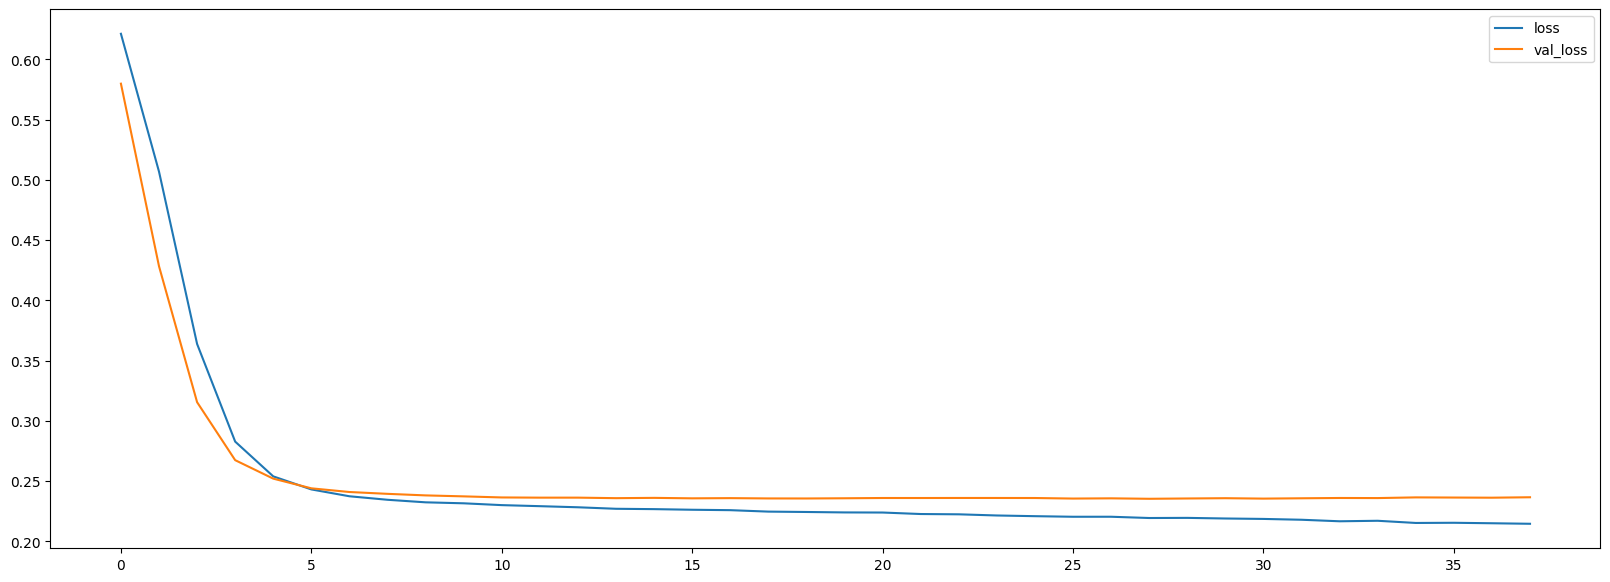

Test ROC Score:  0.8706986463966215


In [61]:
import tqdm
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import CosineAnnealingLR

class Trainer:
    def __init__(self, model, loss_fn, optimizer, scheduler=None):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.history = {'losses': [], 'val_losses': []}

    def fit(self, train_loader, val_loader, epochs, verbose=1, patience=None):
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(1, epochs + 1):
            self.model.train()
            train_losses = []

            with tqdm.tqdm(train_loader, unit="batch", mininterval=0, disable=(not verbose)) as bar:
                bar.set_description(f"Epoch {epoch}")
                for X_batch, y_batch in bar:
                    self.optimizer.zero_grad()
                    y_pred = self.model(X_batch)
                    loss = self.loss_fn(y_pred, y_batch)
                    loss.backward()
                    self.optimizer.step()

                    train_losses.append(loss.item())
                    bar.set_postfix(loss=float(loss))

                avg_train_loss = sum(train_losses) / len(train_losses)
                self.history['losses'].append(avg_train_loss)

                # Validation
                self.model.eval()
                val_losses = []

                with torch.no_grad():
                    for X_val, y_val in val_loader:
                        y_pred_val = self.model(X_val)
                        val_loss = self.loss_fn(y_pred_val, y_val)
                        val_losses.append(val_loss.item())

                avg_val_loss = sum(val_losses) / len(val_losses)
                self.history['val_losses'].append(avg_val_loss)

                # Update learning rate if scheduler is provided
                if self.scheduler is not None:
                    self.scheduler.step()

                # Early stopping
                if patience is not None:
                    if avg_val_loss < best_val_loss:
                        best_val_loss = avg_val_loss
                        patience_counter = 0
                    else:
                        patience_counter += 1

                    if patience_counter >= patience:
                        print(f"Early stopping after {epoch} epochs with no improvement.")
                        break

        return self.history

# Create model, optimizer, scheduler
neural_model = MLP(input_size=X.shape[1], num_blocks=6, mlp_mult=4, dropout=0.2, output_size=len(target))
neural_model.to(device)
optimizer = torch.optim.Adam(neural_model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=200, verbose=True)

# Wrap the model, loss, optimizer, and scheduler in Trainer
trainer = Trainer(neural_model, nn.BCELoss(), optimizer, scheduler)

# Fit the model using Trainer
history = trainer.fit(train_loader, test_loader, epochs=200, verbose=1, patience=10)

# Plot the training history
plt.figure(figsize=(20, 7))
plt.plot(range(len(history['losses'])), history['losses'])
plt.plot(range(len(history['val_losses'])), history['val_losses'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

# Make predictions on the test set
neural_model.eval()
with torch.no_grad():
    y_pred_val = neural_model(X_val_tensor).cpu().numpy()

test_score = roc_auc_score(y_val_tensor.cpu().numpy(), y_pred_val)
print('Test ROC Score: ', test_score)

In [62]:
# Save the model
torch.save(neural_model.state_dict(), 'neural_model.pth')

In [63]:
# Load the model
# model = Network()  # Create an instance of your model class
# model.load_state_dict(torch.load('model.pth'))
# model.eval()  # Set the model to evaluation mode after loading

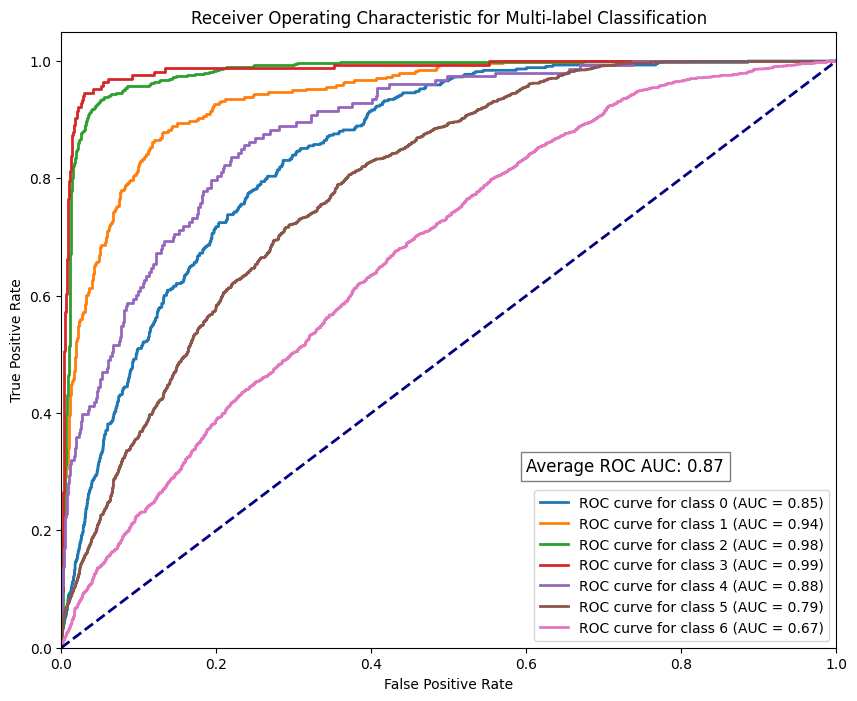

In [64]:
# Make predictions on the validation set
neural_model.eval()
with torch.no_grad():
    y_pred_val = neural_model(X_val_tensor).cpu().numpy()

# Convert y_val_tensor to a numpy array
y_val_np = y_val_tensor.cpu().numpy()

# Compute the ROC curve and AUC for each target class
plt.figure(figsize=(10, 8))
auc_scores = []
for i in range(y_pred_val.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_val_np[:, i], y_pred_val[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(i, roc_auc))

# Calculate the average ROC AUC score
avg_roc_auc = np.mean(auc_scores)

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot attributes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-label Classification')
plt.legend(loc="lower right")
# Add the average ROC AUC score to the plot
plt.text(0.6, 0.3, f'Average ROC AUC: {avg_roc_auc:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()


# Hyperparameter tuning

Average ROC AUC score: 0.8844234853684021


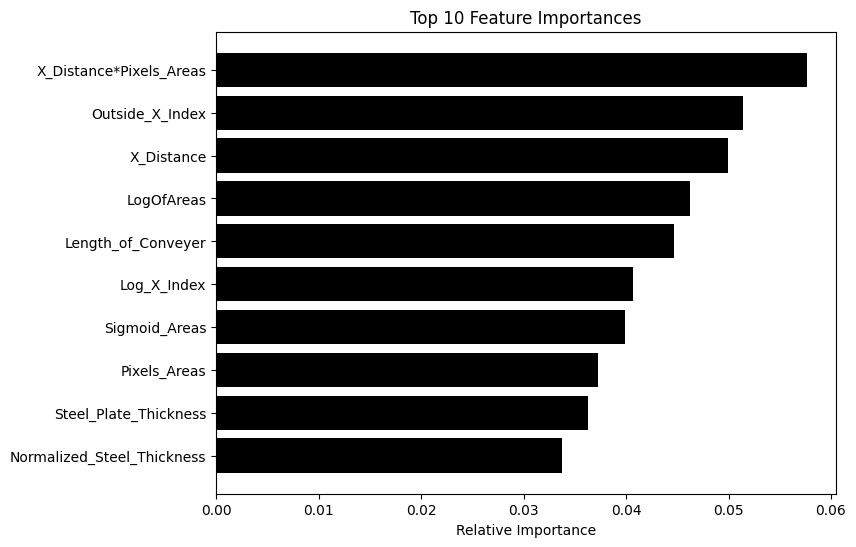

In [65]:
from sklearn.ensemble import RandomForestClassifier

params = {
        "random_state": 42,
        "n_estimators" : 830,
        "max_depth" : 17,
        "min_samples_split" : 5,
        "min_samples_leaf" : 12,
        "max_features" : 'sqrt',
        "criterion" : 'log_loss'
    }

# Classification model
rf = RandomForestClassifier(**params)

# Cross validation and performance evaluation
cv_eval(X_train, y_train, rf)

# Plot top-10 features
plot_importance(rf, X)

In [67]:
joblib.dump(rf, 'best_rf_model.pkl')

['best_rf_model.pkl']

Average ROC AUC score: 0.8845093994101434


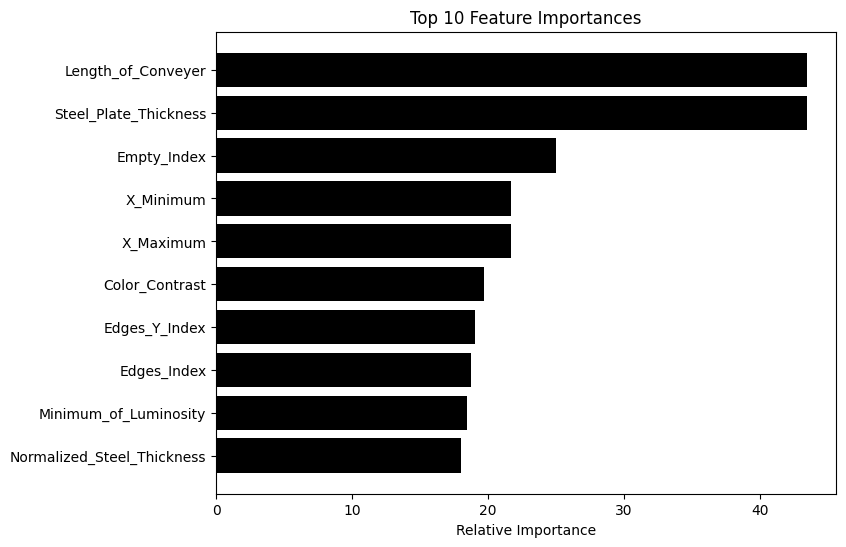

In [69]:
from lightgbm import LGBMClassifier

params = {"random_state": 42,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": 6.44409300139458e-07,
        "lambda_l2": 8.344952335461669e-06,
        "num_leaves": 8,
        "feature_fraction": 0.4596282441093633,
        "bagging_fraction": 0.815721191919045,
        "bagging_freq": 5,
        "min_child_samples": 87}

# Classification model
lgbm = MultiOutputClassifier(LGBMClassifier(**params))

# Cross validation and performance evaluation
cv_eval(X_train, y_train, lgbm)

# Plot top-10 features
plot_multi_importance(lgbm, X)
filename = "lightgbm.pkl"
pickle.dump(lgbm, open(filename, "wb"))

Average ROC AUC score: 0.8862901124809739


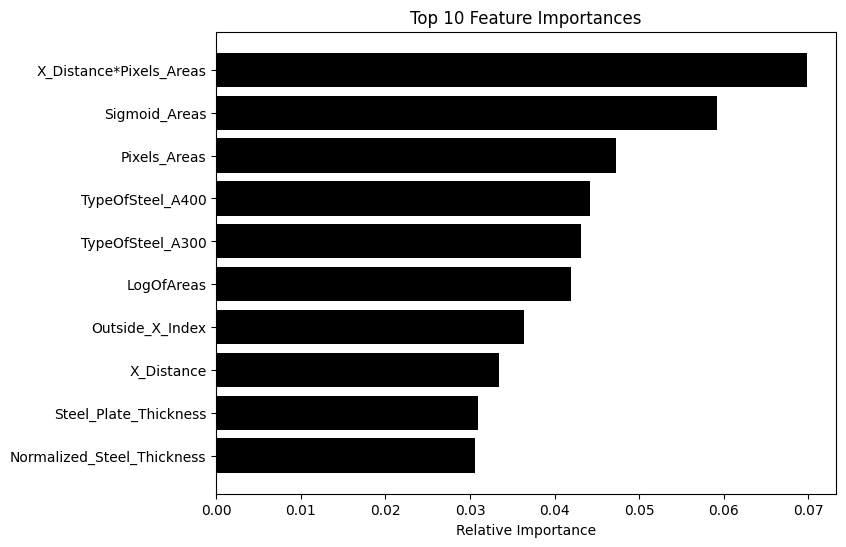

In [70]:
from xgboost import XGBClassifier

params = {
    "objective": "binary:logistic",
    "verbosity": 0,
    "eval_metric": "error",
    "n_estimators": 540,
    "learning_rate": 0.010833092026630435,
    "max_depth": 5,
    "subsample": 0.8950178662448546,
    "colsample_bytree": 0.6474419107649793,
    "min_child_weight": 6,
}

# Classification model
xgb = MultiOutputClassifier(XGBClassifier(**params))

# Cross validation and performance evaluation
cv_eval(X_train, y_train, xgb)

# Plot top-10 features
plot_multi_importance(xgb, X)


In [71]:
joblib.dump(xgb, 'best_xgb_model.pkl')

['best_xgb_model.pkl']

Average ROC AUC score: 0.8823745474749352


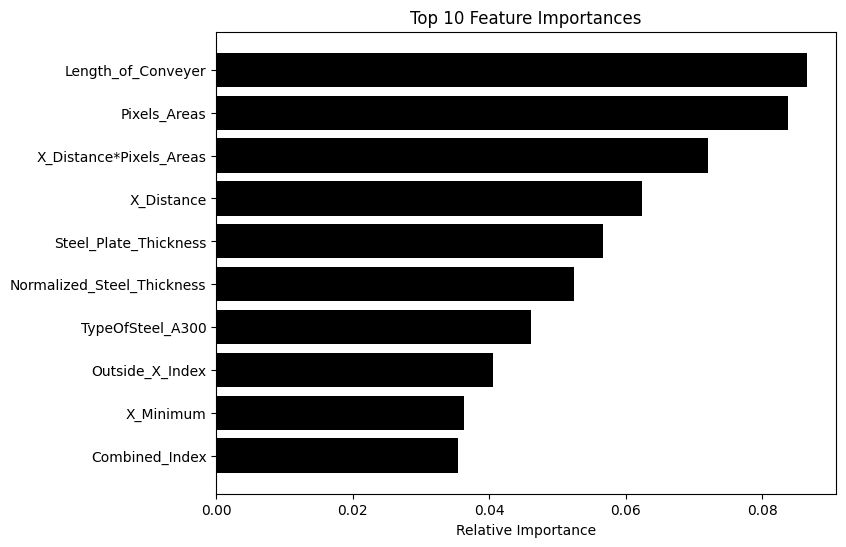

In [72]:
# Classification model
gb = MultiOutputClassifier(GradientBoostingClassifier(random_state=42))

# Cross validation and performance evaluation
cv_eval(X_train, y_train, gb)

# Plot top-10 features
plot_multi_importance(gb, X)


In [73]:
joblib.dump(gb, 'best_gb_model.pkl')

['best_gb_model.pkl']

# Ensemble Voting classifier

In [76]:
# Weight optimization for voting classifier
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import VotingClassifier

def manual_ensemble(models, X, weight_1, weight_2, weight_3, weight_4):
    """
    Predict with an ensemble of models and weights.
    
    :param models: List of trained models.
    :param X: Feature data for prediction.
    :param weights: List of weights for each model.
    :return: Weighted average prediction.
    """

    # Normalize weights to sum to 1
    weights = np.array([weight_1, weight_2, weight_3, weight_4, 1])
    weights = weights / np.sum(weights)

    # Initialize a list to store weighted predictions
    weighted_predictions = []
    
    for i, model in enumerate(models):
        prediction = model.predict_proba(X)
        if not isinstance(prediction, np.ndarray):
            prediction = np.array(prediction)
        weighted_prediction = prediction * weights[i]
        weighted_predictions.append(weighted_prediction)
    average_prediction = np.sum(weighted_predictions, axis=0)
    return average_prediction

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        'weight_1': trial.suggest_float("weight_1", 0.1, 1.0),
        'weight_2': trial.suggest_float("weight_2", 0.1, 1.0),
        'weight_3': trial.suggest_float("weight_3", 0.1, 1.0),
        'weight_4': trial.suggest_float("weight_4", 0.1, 1.0),
    }

    mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for _, valid_idx in mskf.split(X_train, y_train):
        X_valid_fold, y_valid_fold = X_train[valid_idx], y_train.iloc[valid_idx]
        
        y_pred_fold = manual_ensemble([rf, gb, xgb, lgbm], X_valid_fold, **param)
        score = avg_auc(y_valid_fold, y_pred_fold)
        scores.append(score)

    return np.mean(scores)

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="voting", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.9542339410612192
  Params: 
    weight_1: 0.978515728103387
    weight_2: 0.2667422781969373
    weight_3: 0.10245299481003806
    weight_4: 0.11384205706350176


In [87]:
predictions = manual_ensemble([rf, gb, xgb, lgbm], test, **study.best_trial.params)

# Extracting the second column from each array
submit = pd.DataFrame(data = np.column_stack([arr[:, 1] for arr in predictions]),
                     columns=target)

test2 = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
submit.insert(0, 'id', test2['id']) 
submit.to_csv('submission.csv',index=False)
submit

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.263429,0.006035,0.002513,0.000164,0.015194,0.081259,0.230554
1,19220,0.165447,0.017665,0.007786,0.000240,0.073516,0.090643,0.201329
2,19221,0.002765,0.034433,0.035349,0.002105,0.005658,0.194632,0.258456
3,19222,0.065672,0.010572,0.001641,0.001944,0.004784,0.204885,0.264314
4,19223,0.005883,0.007926,0.001402,0.002250,0.005849,0.296309,0.265711
...,...,...,...,...,...,...,...,...
12809,32028,0.062736,0.074036,0.004847,0.000383,0.023277,0.131118,0.213714
12810,32029,0.086211,0.005049,0.011039,0.007314,0.093467,0.102489,0.272291
12811,32030,0.000576,0.000769,0.555271,0.000168,0.000356,0.001673,0.042255
12812,32031,0.210184,0.010207,0.010657,0.000137,0.048171,0.081822,0.214572


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

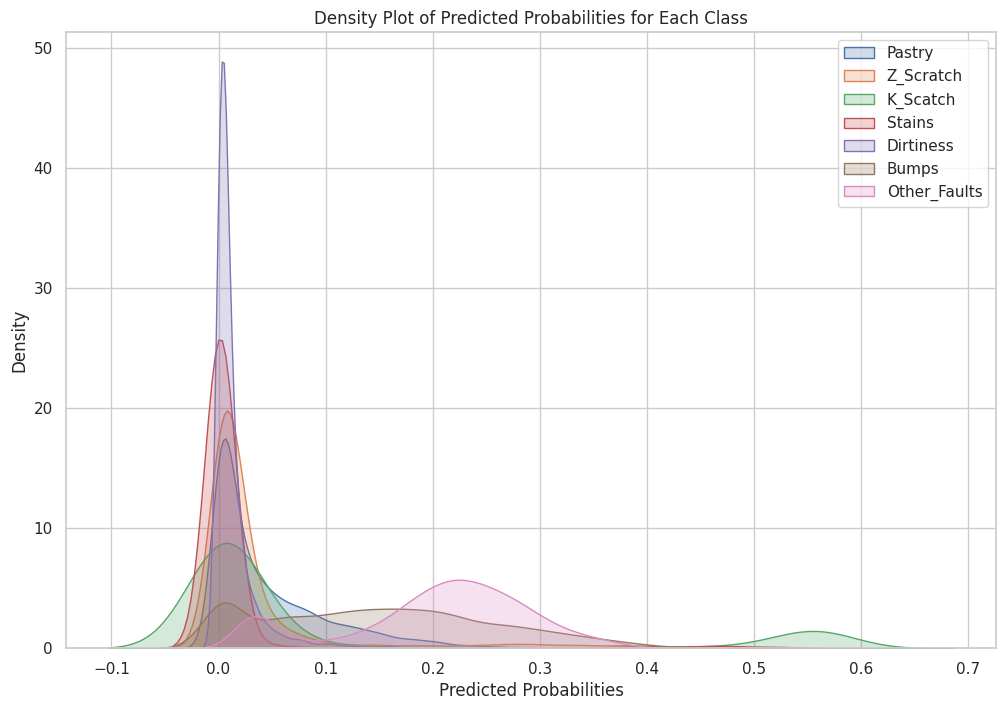

In [86]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Specify the columns you want to plot (excluding the 'id' column)
columns_to_plot = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

# Plot density plot for each category
plt.figure(figsize=(12, 8))
for column in columns_to_plot:
    sns.kdeplot(data=submit[column], label=column, fill=True)
    
plt.title('Density Plot of Predicted Probabilities for Each Class')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Density')
plt.legend()
plt.show()

# submission for our neural network

In [90]:
# Move the test data to the CUDA device if available
test_tensor = torch.tensor(test, dtype=torch.float32).to(device)

# Generate predictions using the neural model
with torch.no_grad():
    neural_model.eval()  # Set the model to evaluation mode
    preds_neural = neural_model(test_tensor).cpu().numpy() 

id_df2 = pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv')
ids2 = id_df2['id']

# Create the submission DataFrame
submission2 = pd.DataFrame(preds_neural, columns=y_train.columns)
submission2.insert(0, 'id', ids2)


# submission2.to_csv('submission.csv', index=False)

In [92]:
display(submission2)

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.562977,0.005660,0.000863,0.000765,0.017614,0.144704,0.310230
1,19220,0.244143,0.010023,0.004444,0.003368,0.174545,0.087339,0.400717
2,19221,0.004625,0.034967,0.092474,0.003230,0.007294,0.275311,0.491755
3,19222,0.127459,0.000683,0.000335,0.001263,0.003939,0.508657,0.357880
4,19223,0.001210,0.002758,0.001869,0.000406,0.001784,0.683247,0.324239
...,...,...,...,...,...,...,...,...
12809,32028,0.144530,0.095446,0.003594,0.000817,0.023815,0.264526,0.333455
12810,32029,0.218380,0.004668,0.004562,0.012623,0.246572,0.076916,0.418941
12811,32030,0.000400,0.001126,0.921363,0.002303,0.000295,0.001598,0.126282
12812,32031,0.478416,0.004021,0.009138,0.001210,0.060090,0.105973,0.308871


In [101]:
# Combine predictions by averaging
combined_predictions = (submission2.drop(columns=['id'], axis=1) + submit.drop(columns=['id'], axis=1)) / 2
combined_predictions.insert(0, 'id', ids2)

# Display the combined predictions
display(combined_predictions)
combined_predictions.to_csv('submission2.csv', index=False)

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.413203,0.005848,0.001688,0.000464,0.016404,0.112982,0.270392
1,19220,0.204795,0.013844,0.006115,0.001804,0.124031,0.088991,0.301023
2,19221,0.003695,0.034700,0.063912,0.002667,0.006476,0.234971,0.375106
3,19222,0.096565,0.005627,0.000988,0.001603,0.004361,0.356771,0.311097
4,19223,0.003546,0.005342,0.001636,0.001328,0.003816,0.489778,0.294975
...,...,...,...,...,...,...,...,...
12809,32028,0.103633,0.084741,0.004221,0.000600,0.023546,0.197822,0.273585
12810,32029,0.152296,0.004859,0.007800,0.009969,0.170020,0.089703,0.345616
12811,32030,0.000488,0.000947,0.738317,0.001236,0.000326,0.001635,0.084268
12812,32031,0.344300,0.007114,0.009898,0.000674,0.054131,0.093898,0.261722


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

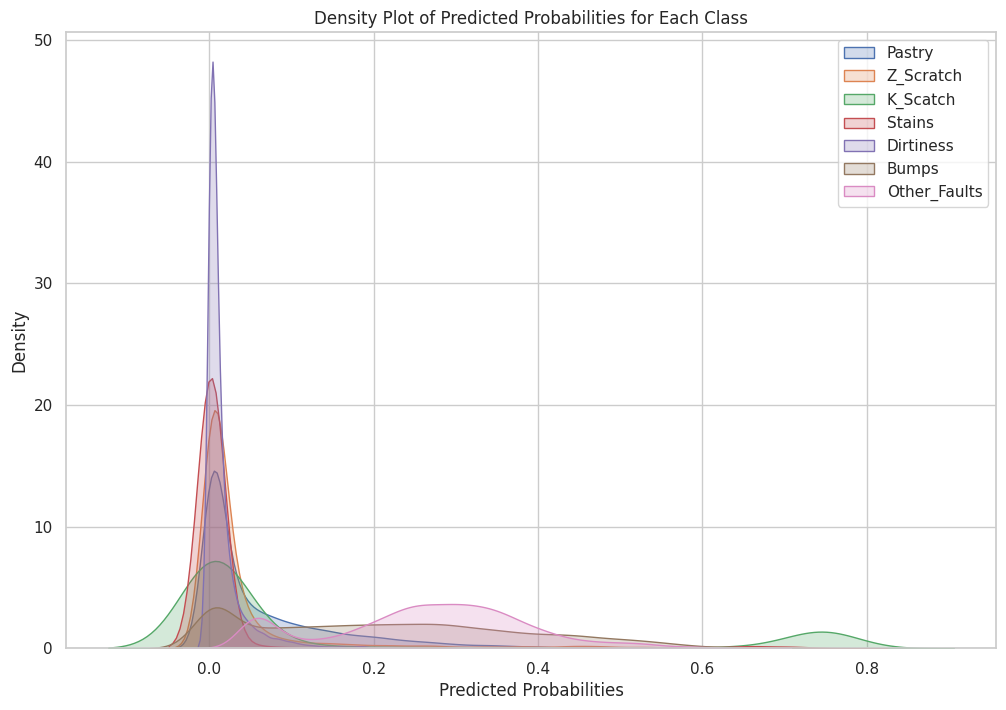

In [95]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Specify the columns you want to plot (excluding the 'id' column)
columns_to_plot = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

# Plot density plot for each category
plt.figure(figsize=(12, 8))
for column in columns_to_plot:
    sns.kdeplot(data=combined_predictions[column], label=column, fill=True)
    
plt.title('Density Plot of Predicted Probabilities for Each Class')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Density')
plt.legend()
plt.show()

In [106]:
from sklearn.model_selection import KFold

# Get predictions from base models
rf_pred_train = rf.predict_proba(X_train)
gb_pred_train = gb.predict_proba(X_train)
xgb_pred_train = xgb.predict_proba(X_train)
lgbm_pred_train = lgbm.predict_proba(X_train)

# Concatenate base model predictions
base_model_predictions_train = np.column_stack((rf_pred_train, gb_pred_train, xgb_pred_train, lgbm_pred_train))
# Transpose base model predictions to (7, 53812, 2)
base_model_predictions_train_transposed = np.transpose(base_model_predictions_train, axes=(1, 0, 2))

# Convert the transposed predictions to a PyTorch tensor
base_model_predictions_train_tensor = torch.FloatTensor(base_model_predictions_train_transposed)

# Convert labels to tensor
y_train_tensor = torch.LongTensor(y_train.values)  




In [113]:
print(base_model_predictions_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([53812, 7, 2])
torch.Size([13453, 7])


In [ ]:
dummy_dataset = TensorDataset(base_model_predictions_train_tensor, y_train_tensor)
dummy_loader = DataLoader(dummy_dataset, batch_size=64) 

In [112]:
iimport numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


# Step 2: Build XGBoost Models
num_models = 15
xgb_models = []



# Step 3: Combine Features
X_combined = np.hstack(xgb_models)  # Combine predicted probabilities from all models

# Step 4: Train Neural Network
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)  # Example NN model
nn_model.fit(X_combined, y_test)

# Evaluate the trained neural network
y_pred = nn_model.predict(X_combined)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (376684x2 and 49x49)